In [2]:

import tensorflow as tf
from tensorflow.data import Dataset
from matplotlib import pyplot as plt
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))


# tf.test.gpu_device_name()

if gpus:
    try:
        for gpu in gpus:
            print('Set GPU ', gpu, ' memory growth to True')
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices('GPU')
        print('Physical GPUs ', len(gpus), ', Logical GPUs ', len(logical_gpus))
    except RuntimeError as e:
        print(e)
    
from transformers import BertTokenizer, TFBertForSequenceClassification
from tqdm.notebook import tqdm
import pandas as pd
import argparse

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os

2022-06-09 09:55:14.266914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 09:55:14.319131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 09:55:14.319257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Num GPUs Available:  1
Set GPU  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')  memory growth to True
Physical GPUs  1 , Logical GPUs  1


2022-06-09 09:55:14.321072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-09 09:55:14.322265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 09:55:14.322434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 09:55:14.322703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
DATASET = './datasets/all-data.csv'
BERT_BASED_UNCASED = './datasets/bert-base-uncased/'
MODEL_OUTPUT = './output'

if os.path.exists(MODEL_OUTPUT) == False:
    os.mkdir(MODEL_OUTPUT)

In [3]:
def convert_to_bert_input(df, tokenizer, args):
    input_ids = list()
    token_type_ids = list()
    attention_masks = list()
    labels = []

    for index, row in df.iterrows():
        text = row['text']
        label = row['label']

        bert_input = text_to_bert_input(text, tokenizer, args.max_length)
        input_ids.append(bert_input['input_ids'])
        token_type_ids.append(bert_input['token_type_ids'])
        attention_masks.append(bert_input['attention_mask'])
        labels.append(label)
    
    dataset =  Dataset.from_tensor_slices((input_ids, attention_masks, token_type_ids, labels))\
        .map(map_bert_input_to_dict)\
        .shuffle(args.seed)\
        .batch(args.batch_size)

    dataset_size = len(dataset)
    train_size = int(dataset_size * (1 - args.validation_split))
    train_dataset = dataset.take(train_size)
    valid_dataset = dataset.skip(train_size)

    return train_dataset, valid_dataset

# def dataset_from_dataframe(df, args):
# #Convert pandas df to tensorflow.data.Dataset
#     features = list()
#     labels = list()
#     for index, row in df.iterrows():
#         features.append(row['text'])
#         labels.append(row['label'])

#     dataset = Dataset.from_tensor_slices((features, labels)).batch(args.batch_size)
#     dataset_size = len(dataset)
#     train_size = int(dataset_size * ( 1 - args.validation_split))

#     train_dataset = dataset.take(train_size)
#     valid_dataset = dataset.skip(train_size)

#     print("fulldataset len = ", len(dataset), ', batch size = ', args.batch_size)
#     print("train dataset len = ", len(train_dataset), ', batch size = ', args.batch_size)
#     print("valid dataset len = ", len(valid_dataset), ', batch size = ', args.batch_size)

#     return train_dataset, valid_dataset

def text_to_bert_input(text, tokenizer, max_length):
    return tokenizer.encode_plus(
        text, 
        add_special_tokens = True,
        return_attention_mask = True,
        # padding='max_length',
        max_length = max_length,
        pad_to_max_length = True,
    )

def map_bert_input_to_dict(input_id, attention_mask, token_type_ids, label):
    return {
        'input_ids': input_id,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_mask,
    }, label

def summarize_diagnostic(history, path = '', description = None):
    plt.figure(figsize=(10,10))
    plt.figtext(0, 1, description, fontsize=15)
    plt.subplot(211)
    plt.title("Loss")
    plt.plot(history.history['loss'], color="blue", label="train loss")
    plt.plot(history.history['val_loss'], color="red", label="validation loss")
    plt.legend()
    plt.subplot(212)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], color="blue", label="train accuracy")
    plt.plot(history.history['val_accuracy'], color="red", label="validation accuracy")
    plt.legend()
    if(path!= ''):
        plt.rcParams['savefig.facecolor'] = 'white'
        plt.savefig(path, dpi = 100, bbox_inches = 'tight')

In [4]:
tokenizer = BertTokenizer.from_pretrained(BERT_BASED_UNCASED,
 do_lower_case = True)
label_encoder = LabelEncoder()

In [5]:
args = argparse.Namespace()
args.batch_size = 8 
args.seed =100 
args.validation_split = 0.15
args.learning_rate = 1e-5
args.epochs = 10
args.model_save_file = os.path.join(MODEL_OUTPUT, f'bert_{args.learning_rate}_{args.epochs}')
args.model_training_chart = os.path.join(MODEL_OUTPUT, f'bert_{args.learning_rate}_{args.epochs}.png')

In [6]:
df = pd.read_csv(DATASET, encoding='ISO-8859-1', header = None, names = ['label', 'text'])

df.dropna(inplace=True)
print(df.describe())
print(df.head())

max_length = max([len(text.split(" ")) for text in df['text']])

args.max_length = max_length

print('max sequence length = ', max_length)

le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
print(df['label'].value_counts())

classes = le.classes_

with open(os.path.join(MODEL_OUTPUT, 'label_encoder_classes.txt'), 'w') as file:
    for c in classes:
        file.write(c+'\n')



          label                                               text
count      4846                                               4846
unique        3                                               4838
top     neutral  TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq       2879                                                  2
      label                                               text
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...
max sequence length =  81
1    2879
2    1363
0     604
Name: label, dtype: int64


In [7]:
train_dataset, valid_dataset = convert_to_bert_input(df, tokenizer, args)
print("Len training dataset ", len(train_dataset))
print("Len valid dataset ", len(valid_dataset))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/nguyen/Desktop/learning-nlp/.env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Len training dataset  515
Len valid dataset  91


In [8]:
# Build a model

model = TFBertForSequenceClassification.from_pretrained(BERT_BASED_UNCASED, num_labels = 3)

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate, epsilon=1e-8),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
)

print(model.summary())

2022-06-08 18:41:03.860212: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ./datasets/bert-base-uncased/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
history = model.fit(
    train_dataset,
    epochs = args.epochs,
    validation_data = valid_dataset
)

Epoch 1/10
515/515 [==============================] - 75s 122ms/step - loss: 0.5296 - accuracy: 0.7896 - val_loss: 0.5899 - val_accuracy: 0.8264
Epoch 2/10
515/515 [==============================] - 61s 118ms/step - loss: 0.3168 - accuracy: 0.8765 - val_loss: 0.4129 - val_accuracy: 0.8430
Epoch 3/10
515/515 [==============================] - 61s 118ms/step - loss: 0.1866 - accuracy: 0.9301 - val_loss: 0.4239 - val_accuracy: 0.8512
Epoch 4/10
515/515 [==============================] - 61s 118ms/step - loss: 0.1363 - accuracy: 0.9527 - val_loss: 0.4015 - val_accuracy: 0.8526
Epoch 5/10
515/515 [==============================] - 61s 118ms/step - loss: 0.0822 - accuracy: 0.9745 - val_loss: 0.4935 - val_accuracy: 0.8512
Epoch 6/10
515/515 [==============================] - 61s 118ms/step - loss: 0.0563 - accuracy: 0.9847 - val_loss: 0.4382 - val_accuracy: 0.8499
Epoch 7/10
515/515 [==============================] - 61s 118ms/step - loss: 0.0442 - accuracy: 0.9857 - val_loss: 0.5579 - val_ac

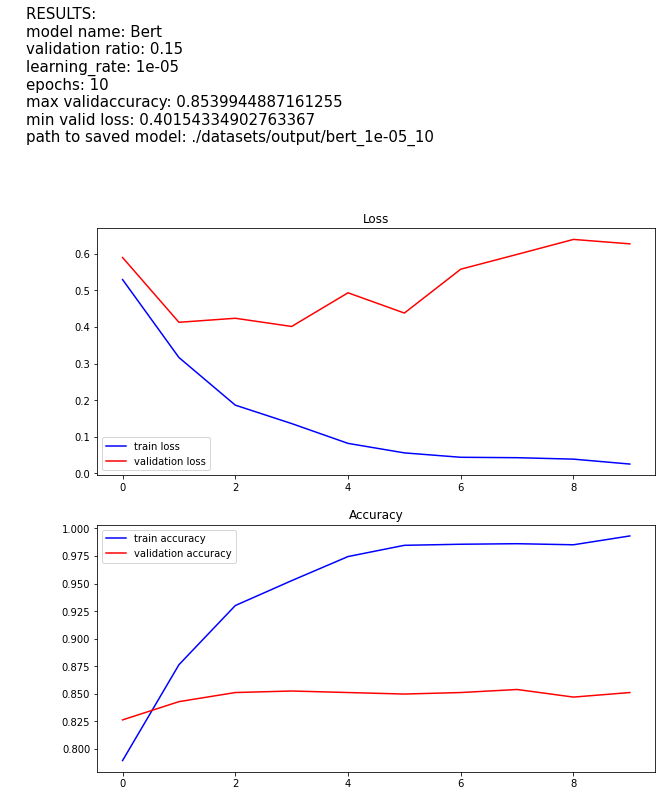

In [10]:
description_text = f"\
    RESULTS:\n\
    model name: Bert\n\
    validation ratio: {args.validation_split}\n\
    learning_rate: {args.learning_rate}\n\
    epochs: {args.epochs}\n\
    max validaccuracy: {np.max(history.history['val_accuracy'])}\n\
    min valid loss: {np.min(history.history['val_loss'])}\n\
    path to saved model: {args.model_save_file}"

summarize_diagnostic(history, args.model_training_chart, description=description_text)

In [11]:
model.save_pretrained(args.model_save_file)

### Load the model and predict on some samples

In [4]:
model = TFBertForSequenceClassification.from_pretrained(os.path.join(MODEL_OUTPUT, 'bert_1e-05_10'))

tokenizer = BertTokenizer.from_pretrained(BERT_BASED_UNCASED,
 do_lower_case = True)
label_encoder = LabelEncoder()

classes = list()
with open(os.path.join(MODEL_OUTPUT, 'label_encoder_classes.txt'), 'r') as file:
    for line in file.readlines():
        classes.append(line.strip())

label_encoder.classes_ = np.asarray(classes)

print("Loaded label encoder classes \n", label_encoder.classes_)


2022-06-09 09:55:24.330273: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./datasets/output/bert_1e-05_10.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Loaded label encoder classes 
 ['negative' 'neutral' 'positive']


In [5]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


In [6]:
samples = [
"Tech’s Decade of Stock-Market Dominance Ends, For Now",
"Dow Jones Falls As Treasury Yields Climb; Tesla Races Higher On Battery Deal",
"Santoli: The volatility of the market’s ‘fear gauge’ is down, sparking some concern on Wall Street",
"Dow Jones Futures Fall After Bullish Market Action; Tesla To Buy Batteries From Top EV Rival",
"Stock market news live updates: Stocks mixed as inflation concerns persist",
"Today's Stock Market News & Events: 6/8/2022",
"Stock market news live updates: Stocks gain in back-and-forth session as volatile trading continues"
]

In [7]:
print("Input :", samples[1])

input = tokenizer(
    samples,
    padding = True,
    max_length = 81,
    truncation=True,
    return_tensors = 'tf'
)

print(input)

X_input = {
    "input_ids": np.asarray(input['input_ids']),
    "token_type_ids": np.asarray(input['token_type_ids']),
    "attention_mask": np.asarray(input['attention_mask']),

}

pred = model.predict(X_input)

print(pred)

Input : Dow Jones Falls As Treasury Yields Climb; Tesla Races Higher On Battery Deal
{'input_ids': <tf.Tensor: shape=(7, 28), dtype=int32, numpy=
array([[  101,  6627,  1521,  1055,  5476,  1997,  4518,  1011,  3006,
        13811,  4515,  1010,  2005,  2085,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  101, 23268,  3557,  4212,  2004,  9837, 16189,  7105,  1025,
        26060,  3837,  3020,  2006,  6046,  3066,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  101, 11685,  3669,  1024,  1996,  5285, 10450, 18605,  1997,
         1996,  3006,  1521,  1055,  1520,  3571,  7633,  1521,  2003,
         2091,  1010, 12125,  2075,  2070,  5142,  2006,  2813,  2395,
          102],
       [  101, 23268,  3557, 17795,  2991,  2044,  7087,  4509,  3006,
         2895,  1025, 26060,  2000,  4965, 10274,  2013,  2327, 23408,
         6538,   102,    

In [10]:
pred_prob = tf.nn.softmax(pred.logits).numpy()
print(pred_prob)
final_pred = tf.argmax(pred_prob, axis = 1).numpy()

print(final_pred)

labels = list(label_encoder.inverse_transform(final_pred))

for sample, label in zip(samples, labels):
    print(f'{sample} : {label}')

[[1.0699389e-02 9.7886515e-01 1.0435497e-02]
 [3.7892688e-02 7.4702191e-01 2.1508537e-01]
 [9.9277520e-01 5.6982180e-03 1.5266078e-03]
 [9.6453035e-01 3.0660169e-02 4.8095314e-03]
 [3.9531690e-01 6.0254341e-01 2.1397178e-03]
 [5.1157334e-04 9.9926358e-01 2.2476567e-04]
 [6.1349786e-04 9.9852282e-01 8.6369831e-04]]
[1 1 0 0 1 1 1]
Tech’s Decade of Stock-Market Dominance Ends, For Now : neutral
Dow Jones Falls As Treasury Yields Climb; Tesla Races Higher On Battery Deal : neutral
Santoli: The volatility of the market’s ‘fear gauge’ is down, sparking some concern on Wall Street : negative
Dow Jones Futures Fall After Bullish Market Action; Tesla To Buy Batteries From Top EV Rival : negative
Stock market news live updates: Stocks mixed as inflation concerns persist : neutral
Today's Stock Market News & Events: 6/8/2022 : neutral
Stock market news live updates: Stocks gain in back-and-forth session as volatile trading continues : neutral
